# **WQU Capstone Project**

### **Dynamic MACD Trading with Multi-modal Agent**

#### **Student Group 6386**
##### Sunil Sharma ([sunilksh+mscfe@outlook.com](mailto:sunilksh+mscfe@outlook.com))

---

### Objective

The objective of the notebook explore approach of integration of an AI agent(AutoGen) together with Multimodal LLM(GPT-4o) to optimize Moving Average Convergence Divergence (MACD) trading strategy for a stock of company. This involves:

- Plotting historical stock price data with MACD indicators.
- Visually inspect the generated plots to establish initial MACD parameters.
- Back test the MACD trading strategy with selected parameters.
- Iteratively optimize the MACD parameters using back testing results.
- Conclude about the best MACD strategy/parameters.

### Imports

In [1]:
# Agent-related imports
import autogen
from autogen import AssistantAgent, UserProxyAgent, register_function
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.cache import Cache

# Data manipulation and handling
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import Image, display

# Backtesting and trading analysis
import backtrader as bt

# Standard library imports
import json
import os
from textwrap import dedent
from typing import Optional, Dict, Annotated

### Configuration and Constants

In [2]:
company = "AAKASH"
start_date = "2022-01-01"
end_date = "2024-01-01"
file_path = f'../../data/DailyData/{company}.csv'

In [3]:
def load_config(filter_model: str):
    return autogen.config_list_from_json(
        "./CONFIG.json",
        filter_dict={"model": [filter_model]},
    )

config_list_4o = load_config("gpt-4o")
config_list = load_config("gpt-4o")

llm_config_4o = {"config_list": config_list_4o,"max_tokens":300,"temperature": 0.0}
llm_config = {"config_list": config_list,"max_tokens":300,"temperature": 0.0}

### Data Processing Classes

In [4]:
class MACDDataProcessor:
    def __init__(self, csv_file_path: str):
        self.data = pd.read_csv(csv_file_path, parse_dates=['date'])
        self.data.set_index('date', inplace=True)

    def filter_data(self, start_date: str, end_date: str):
        self.filtered_data = self.data.loc[start_date:end_date]

    def calculate_ema(self, period: int):
        return self.filtered_data['close'].ewm(span=period, adjust=False).mean()

    def calculate_macd(self):
        ema_fast = self.calculate_ema(12)
        ema_slow = self.calculate_ema(26)
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=9, adjust=False).mean()
        histogram = macd - signal
        return ema_fast, ema_slow, macd, signal, histogram

    def get_filtered_data(self):
        return self.filtered_data.to_dict()

    def get_macd_components(self):
        ema_fast, ema_slow, macd, signal, histogram = self.calculate_macd()
        return {
            'ema_fast': ema_fast.to_dict(),
            'ema_slow': ema_slow.to_dict(),
            'macd': macd.to_dict(),
            'signal': signal.to_dict(),
            'histogram': histogram.to_dict()
        }

### Plotting Class

In [5]:
class MACDPlotter:
    def __init__(self, csv_file_path: str):
        self.data = pd.read_csv(csv_file_path, parse_dates=['date'])
        self.data.set_index('date', inplace=True)

    def filter_data(self, start_date: str, end_date: str):
        self.filtered_data = self.data.loc[start_date:end_date]

    def calculate_ema(self, period: int):
        return self.filtered_data['close'].ewm(span=period, adjust=False).mean()

    def calculate_macd(self):
        ema_fast = self.calculate_ema(12)
        ema_slow = self.calculate_ema(26)
        macd = ema_fast - ema_slow
        signal = macd.ewm(span=9, adjust=False).mean()
        histogram = macd - signal
        return ema_fast, ema_slow, macd, signal, histogram

    def plot_macd(self, save_path: str, plot_type: str = "candle", plot_style: str = "default", show_nontrading: bool = False):
        ema_fast, ema_slow, macd, signal, histogram = self.calculate_macd()

        ema_fast_plot = mpf.make_addplot(ema_fast, color='red', width=2.0, secondary_y=False)
        ema_slow_plot = mpf.make_addplot(ema_slow, color='green', width=2.0, secondary_y=False)

        histogram_positive = histogram.where(histogram >= 0)
        histogram_negative = histogram.where(histogram < 0)

        histogram_positive_plot = mpf.make_addplot(histogram_positive, panel=1, type='bar', color='green', secondary_y=False, width=0.8)
        histogram_negative_plot = mpf.make_addplot(histogram_negative, panel=1, type='bar', color='red', secondary_y=False, width=0.8)
        macd_plot = mpf.make_addplot(macd, panel=1, color='blue', width=2.0, secondary_y=True)
        signal_plot = mpf.make_addplot(signal, panel=1, color='magenta', width=2.0, secondary_y=True)
        apds = [ema_fast_plot, ema_slow_plot, histogram_positive_plot, histogram_negative_plot, macd_plot, signal_plot]

        plot_params = {
            "type": plot_type,
            "style": plot_style,
            "addplot": apds,
            "volume": True,
            "title": "MACD with EMA and Histogram",
            "ylabel": "Price",
            "ylabel_lower": "Volume",
            "show_nontrading": show_nontrading,
            "savefig": save_path,
            "figsize": (12, 8),
            "datetime_format": '%b %Y',
        }

        fig, axlist = mpf.plot(self.filtered_data, **plot_params, returnfig=True)

        fig.subplots_adjust(top=0.9)
        fig.suptitle('MACD with EMA and Histogram', y=0.95, fontsize=12)

        legend_lines = [
            axlist[0].plot([], [], color='red', linewidth=2, label='EMA Fast')[0],
            axlist[0].plot([], [], color='green', linewidth=2, label='EMA Slow')[0],
            axlist[2].plot([], [], color='blue', linewidth=2, label='MACD')[0],
            axlist[2].plot([], [], color='magenta', linewidth=2, label='Signal')[0],
        ]
        axlist[0].legend(handles=legend_lines[:2], loc='upper left')
        axlist[2].legend(handles=legend_lines[2:], loc='upper left')

        plt.close(fig)

        return f"MACD chart saved to {save_path}"


### Backtesting Strategy and Utility Class

In [6]:
class MACDStrategy(bt.Strategy):
    params = (('short_ema', 12), ('long_ema', 26), ('signal_ema', 9),)

    def __init__(self):
        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.params.short_ema,
            period_me2=self.params.long_ema,
            period_signal=self.params.signal_ema
        )
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

    def next(self):
        if self.crossover > 0:
            self.buy()
        elif self.crossover < 0:
            self.sell()

class BackTraderUtils:
    def back_test_macd(
        self,
        csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
        start_date: Annotated[str, "Start date of the backtest in 'YYYY-MM-DD' format"],
        end_date: Annotated[str, "End date of the backtest in 'YYYY-MM-DD' format"],
        strategy_params: Annotated[str, "JSON string of strategy parameters, e.g., '{\"fast_ema\": 12, \"slow_ema\": 26, \"signal_ema\": 9}'"] = "",
        cash: Annotated[float, "Initial cash for backtesting"] = 10000.0,
        save_fig: Optional[Annotated[str, "File path to save the backtest result plot"]] = None,
    ) -> str:
        """
        Use the Backtrader library to backtest the MACD strategy on historical stock data from a CSV file.
        """
        cerebro = bt.Cerebro()
        strategy_class = MACDStrategy
        try:
            strategy_params_dict = json.loads(strategy_params) if strategy_params else {}
        except json.JSONDecodeError:
            return "Error: Invalid JSON format for strategy_params."

        cerebro.addstrategy(strategy_class, **strategy_params_dict)

        # Read data from CSV file
        try:
            df = pd.read_csv(csv_file_path, parse_dates=['date'])
        except FileNotFoundError:
            return f"Error: File not found at {csv_file_path}."
        except pd.errors.ParserError:
            return "Error: Failed to parse CSV file."

        df['datetime'] = pd.to_datetime(df['date'])
        df.set_index('datetime', inplace=True)
        df = df[['open', 'high', 'low', 'close', 'volume']]

        # Filter the data based on the start and end date
        df = df.loc[start_date:end_date]
        
        # Ensure there are enough data points for the MACD calculation
        if len(df) < max(strategy_params_dict.get('short_ema', 12), strategy_params_dict.get('long_ema', 26), strategy_params_dict.get('signal_ema', 9)):
            return "Error: Not enough data available for the specified date range to calculate MACD."

        if df.empty:
            return "Error: No data available for the specified date range."
        
        # Rename columns to match Backtrader expectations
        df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

        # Create a data feed
        data = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(data)  # Add the data feed
        
        # Set our desired cash start
        cerebro.broker.setcash(cash)

        # Attach analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio")
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name="draw_down")
        cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")

        stats_dict: Dict[str, any] = {"Starting Portfolio Value": cerebro.broker.getvalue()}

        results = cerebro.run()  
        first_strategy = results[0]

        # Access analysis results
        stats_dict["Final Portfolio Value"] = cerebro.broker.getvalue()
        stats_dict["Sharpe Ratio"] = (
            first_strategy.analyzers.sharpe_ratio.get_analysis()
        )
        stats_dict["Drawdown"] = first_strategy.analyzers.draw_down.get_analysis()
        stats_dict["Returns"] = first_strategy.analyzers.returns.get_analysis()
        stats_dict["Trade Analysis"] = (
            first_strategy.analyzers.trade_analyzer.get_analysis()
        )

        if save_fig:
            directory = os.path.dirname(save_fig)
            if directory:
                os.makedirs(directory, exist_ok=True)
            plt.figure(figsize=(16, 10))
            cerebro.plot()
            plt.savefig(save_fig)
            plt.close()

        return "Back Test Finished. Results: \n" + json.dumps(stats_dict, indent=2)

### Tool Functions 

In [7]:
def plot_macd_tool(
    csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
    start_date: Annotated[str, "Start date of the historical data in 'YYYY-MM-DD' format"],
    end_date: Annotated[str, "End date of the historical data in 'YYYY-MM-DD' format"],
    save_path: Annotated[str, "File path where the plot should be saved"],
    plot_type: Annotated[str, "Type of the plot (e.g., 'candle', 'line')"] = "candle",
    plot_style: Annotated[str, "Style of the plot (e.g., 'default', 'yahoo')"] = "default",
    show_nontrading: Annotated[bool, "Whether to show non-trading days on the chart"] = False
) -> str:
    plotter = MACDPlotter(csv_file_path)
    plotter.filter_data(start_date, end_date)
    return plotter.plot_macd(save_path, plot_type, plot_style, show_nontrading)

In [8]:
def display_image_tool(file_path: Annotated[str, "Path to the image file to be displayed"]):
    """
    Displays an image from the given file path using IPython.display.
    """
    try:
        display(Image(filename=file_path))
        return f"Displayed image from {file_path}"
    except Exception as e:
        return f"Failed to display image from {file_path}: {e}"

In [9]:
def backtest_macd_tool(
    csv_file_path: Annotated[str, "Path to CSV file containing historical stock data"],
    start_date: Annotated[str, "Start date of the backtest in 'YYYY-MM-DD' format"],
    end_date: Annotated[str, "End date of the backtest in 'YYYY-MM-DD' format"],
    strategy_params: Annotated[str, "JSON string of strategy parameters, e.g., '{\"fast_ema\": 12, \"slow_ema\": 26, \"signal_ema\": 9}'"] = "",
    cash: Annotated[float, "Initial cash for backtesting"] = 10000.0,
    save_fig: Optional[Annotated[str, "File path to save the backtest result plot"]] = None,
) -> str:
    """
    Backtests a MACD strategy on historical stock data from a CSV file.
    """
    utils = BackTraderUtils()
    return utils.back_test_macd(csv_file_path, start_date, end_date, strategy_params, cash, save_fig)

### Agents Configuration

In [10]:
trade_strategy_optimizer = MultimodalConversableAgent(
    name="Trade_Strategy_Optimizer",
    system_message=dedent(
        """
        You are a trading strategy optimizer who inspects financial charts and optimizes trading strategies.
        You have been tasked with developing a Moving average convergence/divergence (MACD) trading strategy.
        You have the following main actions to take:
        1. Ask the Backtesting_Specialist to plot historical stock price data with designated MACD indicators.
        2. Inspect the stock price chart carefully and determine MACD (short_ema,long_ema and signal_ema) parameters.
        3. Highlight the points/periods where the MACD line crosses the Signal line and interpret their significance critically.
        4. Ask the Backtesting_Specialist to backtest the MACD trading strategy with designated parameters to evaluate its performance.
        5. Inspect the backtest result and optimize the MACD parameters based on the returned results.
        6. Avoid testing the same parameters more than 1 time to ensure efficiency.
        Reply TERMINATE when you think the strategy is good enough.
        """
    ),
    llm_config=llm_config_4o,
)

backtesting_specialist = AssistantAgent(
    name="Backtesting_Specialist",
    system_message=dedent(
        f"""
        You are a backtesting speacilist with a strong command of quantitative analysis tools.
        You have two main tasks to perform, choose one each time you are asked by the Trade_Strategy_Optimizer:
        1. Plot historical stock price data for {company} in the file at {file_path} with MACD indicators (short_ema,long_ema and signal_ema) according to the Trade_Strategy_Optimizer's need.
        2. Backtest the MACD trading strategy with designated parameters (short_ema,long_ema and signal_ema) and save the results as an image file.
        For both tasks, after the tool calling, you should do as follows:
            1. display the created & saved image file using the `display_image_tool` tool;
            2. Assume the saved image file is "test.png", reply as follows: "Optimize the MACD parameters(short_ema,long_ema and signal_ema) based on this image <img test.png>. TERMINATE".
        """
    ),
    llm_config=llm_config,
)

backtesting_specialist_executor = UserProxyAgent(
    name="Backtesting_Specialist_Executor",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },
)

### Register Functions

In [11]:
# Register the plot_macd_tool function
register_function(
    plot_macd_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor, 
    name="plot_macd_tool", 
    description="Plots the MACD chart with EMA, MACD histogram, and signals, and saves the plot to a file.",  
)

# Register the backbacktest_macd_tool_test_macd function
register_function(
    backtest_macd_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor,  
    name="backtest_macd_tool", 
    description="Backtests a MACD trading strategy on historical stock data from a CSV file.",  
)

from autogen import register_function

# Register the display_image_tool function
register_function(
    display_image_tool,
    caller=backtesting_specialist,  
    executor=backtesting_specialist_executor,  
    name="display_image_tool",  
    description="Displays an image from the given file path using IPython.display.",  
)

The return type of the function 'display_image_tool' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.


### Reflection Message

In [12]:
def reflection_message_analyst(recipient, messages, sender, config):
    print("Reflecting Trade_Strategy_Optimizer's response ...")
    last_msg = recipient.chat_messages_for_summary(sender)[-1]["content"]
    return (
        "Message from Trade_Strategy_Optimizer is as follows:"
        + last_msg
        + "\n\nBased on this information, conduct a backtest on the specified stock and MACD strategy, and report your backtesting results back to the Trade_Strategy_Optimizer."
    )

### User Proxy and Task Initialization

User_Proxy (to Trade_Strategy_Optimizer):


Based on AAKASH's stock data from 2022-01-01 to 2024-01-01 in the file at ../../data/DailyData/AAKASH.csv, determine the possible optimal parameters for a MACD Strategy over this period.
First, ask the backtesting_specialist to plot a candlestick chart of the stock price data with MACD indicators to visually carefully inspect the price movements and make an initial assessment.
Then, ask the backtesting_specialist to backtest the MACD (short_ema,long_ema and signal_ema) strategy parameters using the backtesting tool, and report results back for further optimization.


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Sure, let's start by asking the Backtesting_Specialist to plot the historical stock price data with the designated MACD indicators.

---

**To Backtesting_Specialist:**

Please plot a candlestick chart of AAKASH's stock price da

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_p8AmNJKCOBuCUtcPGGoew1rU) *****
MACD chart saved to aakash_macd_plot.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

***** Suggested tool call (call_DWDv3hOPnKB3qxi7UjDtTS5v): display_image_tool *****
Arguments: 
{"file_path":"aakash_macd_plot.png"}
***********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION display_image_tool...


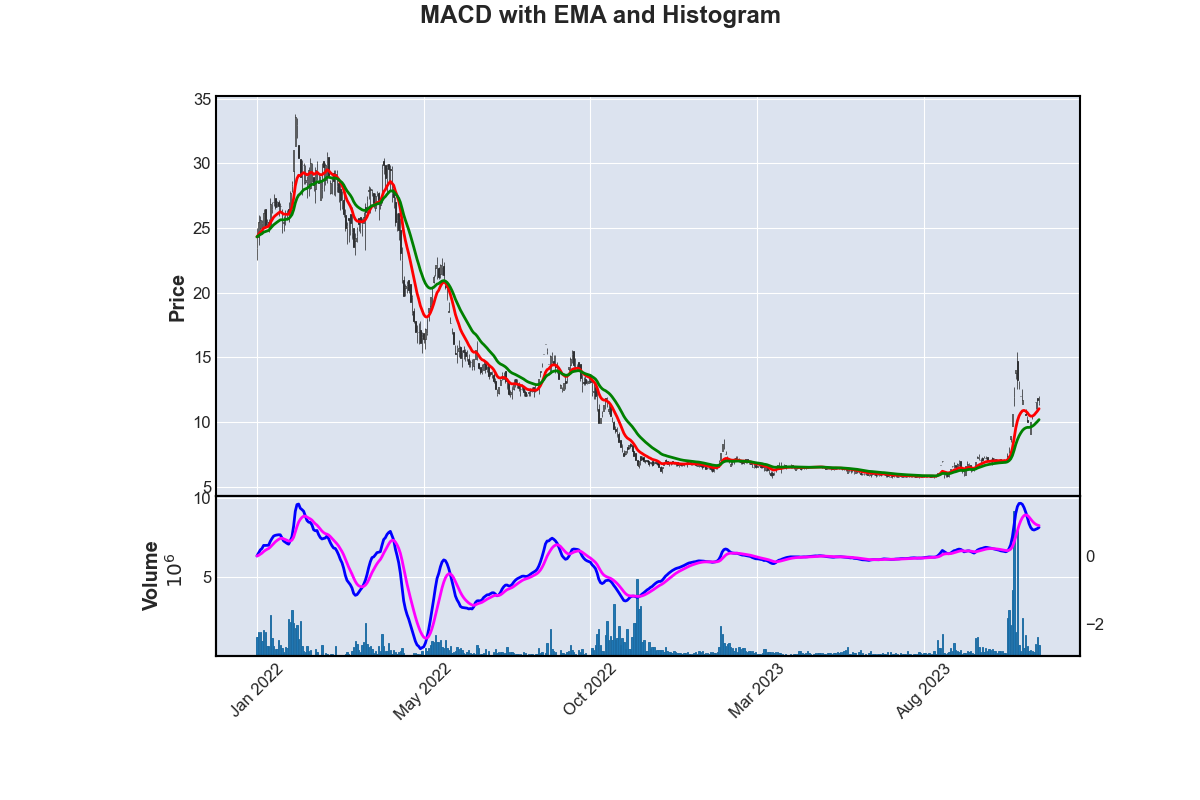

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_DWDv3hOPnKB3qxi7UjDtTS5v) *****
Displayed image from aakash_macd_plot.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img aakash_macd_plot.png>. TERMINATE

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based on the provided chart, we can see the st

<IPython.core.display.Javascript object>

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_M94ifweg0IEzog28arQfiwUq) *****
Back Test Finished. Results: 
{
  "Starting Portfolio Value": 10000.0,
  "Final Portfolio Value": 9992.400000000001,
  "Sharpe Ratio": {
    "sharperatio": -38.62123718221295
  },
  "Drawdown": {
    "len": 361,
    "drawdown": 0.12893166621690139,
    "moneydown": 12.899999999999636,
    "max": {
      "len": 361,
      "drawdown": 0.13742716360327206,
      "moneydown": 13.749999999998181
    }
  },
  "Returns": {
    "rtot": -0.0007602889464086613,
    "ravg": -1.6176360561886411e-06,
    "rnorm": -0.00040756121051633887,
    "rnorm100": -0.040756121051633884
  },
  "Trade Analysis": {
    "total": {
      "total": 17,
      "open": 0,
      "closed": 17
    },
    "streak": {
      "won": {
        "current": 1,
        "longest": 1
      },
      "lost": {
        "current": 0,
        "lo

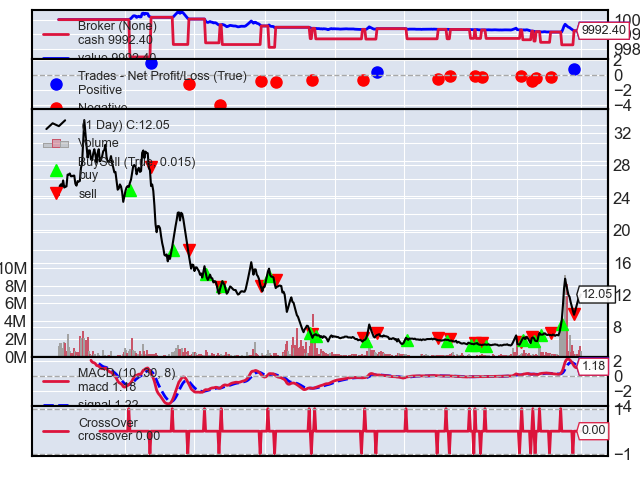

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_LgaE08HUmhGJ3kccW2mgw0D7) *****
Displayed image from backtest_results.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img backtest_results.png>. TERMINATE

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based on the backtest results shown in the ima

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_2EnBaZyeSS0qVsBK1xUZ9MVq) *****
Back Test Finished. Results: 
{
  "Starting Portfolio Value": 10000.0,
  "Final Portfolio Value": 9992.6,
  "Sharpe Ratio": {
    "sharperatio": -31.586537372495883
  },
  "Drawdown": {
    "len": 361,
    "drawdown": 0.1064653987454041,
    "moneydown": 10.649999999999636,
    "max": {
      "len": 361,
      "drawdown": 0.11496263714291037,
      "moneydown": 11.499999999998181
    }
  },
  "Returns": {
    "rtot": -0.0007402739351496404,
    "ravg": -1.5750509258502988e-06,
    "rnorm": -0.00039683407383621106,
    "rnorm100": -0.039683407383621104
  },
  "Trade Analysis": {
    "total": {
      "total": 14,
      "open": 0,
      "closed": 14
    },
    "streak": {
      "won": {
        "current": 1,
        "longest": 1
      },
      "lost": {
        "current": 0,
        "longest": 6
 

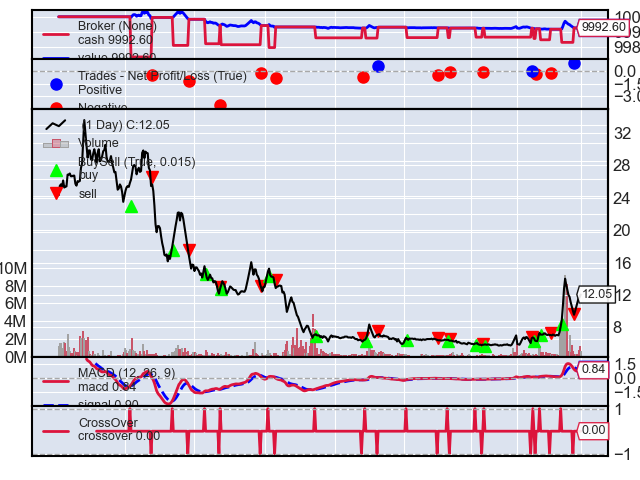

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_y0fewdcP3ShUQNCTyxUNzvtD) *****
Displayed image from backtest_results.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img backtest_results.png>. TERMINATE

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based on the backtest results shown in the ima

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_KT06KbmKcYcNZb4gTEyKeMbv) *****
Back Test Finished. Results: 
{
  "Starting Portfolio Value": 10000.0,
  "Final Portfolio Value": 9992.100000000002,
  "Sharpe Ratio": {
    "sharperatio": -27.299610345734145
  },
  "Drawdown": {
    "len": 393,
    "drawdown": 0.09848079624471773,
    "moneydown": 9.849999999998545,
    "max": {
      "len": 393,
      "drawdown": 0.1054794315108481,
      "moneydown": 10.549999999999272
    }
  },
  "Returns": {
    "rtot": -0.0007903122144435053,
    "ravg": -1.6815153498797985e-06,
    "rnorm": -0.00042365210226392785,
    "rnorm100": -0.04236521022639279
  },
  "Trade Analysis": {
    "total": {
      "total": 12,
      "open": 0,
      "closed": 12
    },
    "streak": {
      "won": {
        "current": 1,
        "longest": 1
      },
      "lost": {
        "current": 0,
        "long

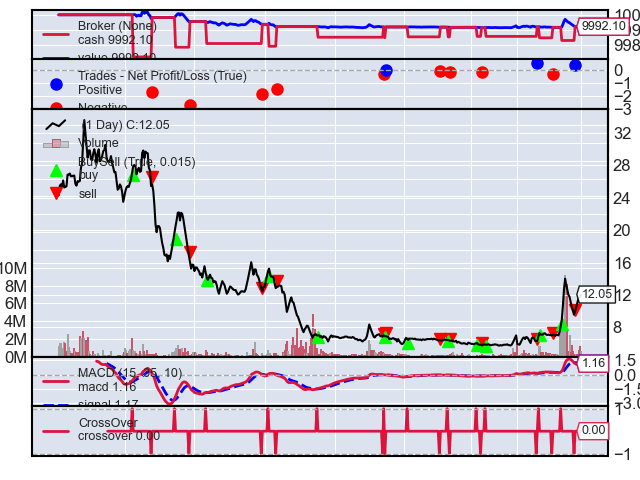

[runtime logging] log_function_use: autogen logger is None


Backtesting_Specialist_Executor (to Backtesting_Specialist):

Backtesting_Specialist_Executor (to Backtesting_Specialist):

***** Response from calling tool (call_E3TfXQl1kZc2KFBcbMDWIE8p) *****
Displayed image from backtest_results.png
**********************************************************************

--------------------------------------------------------------------------------
Backtesting_Specialist (to Backtesting_Specialist_Executor):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <img backtest_results.png>. TERMINATE

--------------------------------------------------------------------------------
User_Proxy (to Trade_Strategy_Optimizer):

Optimize the MACD parameters (short_ema, long_ema, and signal_ema) based on this image <image>. 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Trade_Strategy_Optimizer (to User_Proxy):

Based on the backtest results shown in the ima

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

: 

In [13]:
user_proxy = UserProxyAgent(
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "coding",
        "use_docker": False,
    },
)

user_proxy.register_nested_chats(
    [
        {
            "sender": backtesting_specialist_executor,
            "recipient": backtesting_specialist,
            "message": reflection_message_analyst,
            "max_turns": 10,
            "summary_method": "last_msg",
        }
    ],
    trigger=trade_strategy_optimizer,
)

task = dedent(f"""
    Based on {company}'s stock data from {start_date} to {end_date} in the file at {file_path}, determine the possible optimal parameters for a MACD Strategy over this period.
    First, ask the backtesting_specialist to plot a candlestick chart of the stock price data with MACD indicators to visually carefully inspect the price movements and make an initial assessment.
    Then, ask the backtesting_specialist to backtest the MACD (short_ema,long_ema and signal_ema) strategy parameters using the backtesting tool, and report results back for further optimization.
""")

# Start logging with logger_type and the filename to log to
# logging_session_id = autogen.runtime_logging.start(logger_type="file", config={"filename": "runtime.log"})
# print("Logging session ID: " + str(logging_session_id))

with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=trade_strategy_optimizer, message=task, max_turns=5, summary_method="last_msg"
    )

# autogen.runtime_logging.stop()

The implementation/analysis is ongoing, but we used the mplfinance and Backtrader libraries(based on the experience from previous notebooks) and integrated Autogen AI agent with LLM multimodal vision model GPT-4o for optimization of MACD trading strategies. As per the initial analysis from the notebook, it presents a potential for understanding MACD charts and parameters. The GPT-4o model was mostly right about bullish/bearish trends including MACD line crossings while intial parameters were adjusted iteratively. However, more work needs to be done on fine-tuning prompts alongside model parameters so that interpretation becomes accurate and false signals reduced further.